# Applying Data Science to DS Job Hunting

## Indeed API
Indeed.com offers a publisher's API for adding links in a web page or app. I decided to use this API
to gather a sample of job posting from which to scrape a list of skills.

The API will only return a maximum of 25 url's, so one needs a trick to get a significant amount of data. The trick I'm using now, is to query by zipcode. There are ~43K in the US so that's going to hopefully bring us some hits.
For now, I'm using 500 randomly selected samples of the ~43K zipcodes, returning from 0 to 25 urls from each.

## Parsing Out Skills
To parse out what I think are the skills, I use BeautifulSoup to iterate over the sections locating the bulleted points:
<span class='summary'>
<li> SQL
<li> Python
<li> AWS
</span>

Visual inspection indicates that most of the time, an employer will use a list to itemize the position skills.
It would be cool to run a second supporting project that tries to verify this. How many job posting contain any itemized lists versus those that do not ?
 
### Stop Words
I wanted a way to add new stop words. The word "data" obviously shows up many times and is not helpful.

## Begin Analysis
### Bar Plot 
To count up the parsed skill tokens, I employ SciKit-Learn's CountVectorizer and produce a simple bar plot output.

### Locations
For this example, I'm using all the zipcodes that start with '9', '0' plus 100 randomly selected samples. 

In [171]:
import indeed_scrape
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 8)

%matplotlib inline
ind = indeed_scrape.Indeed()
ind.query = "director media"
ind.add_loc = '94' # Bay Area zip codes
ind.num_samp = 0
#ind.stop_words = "media"

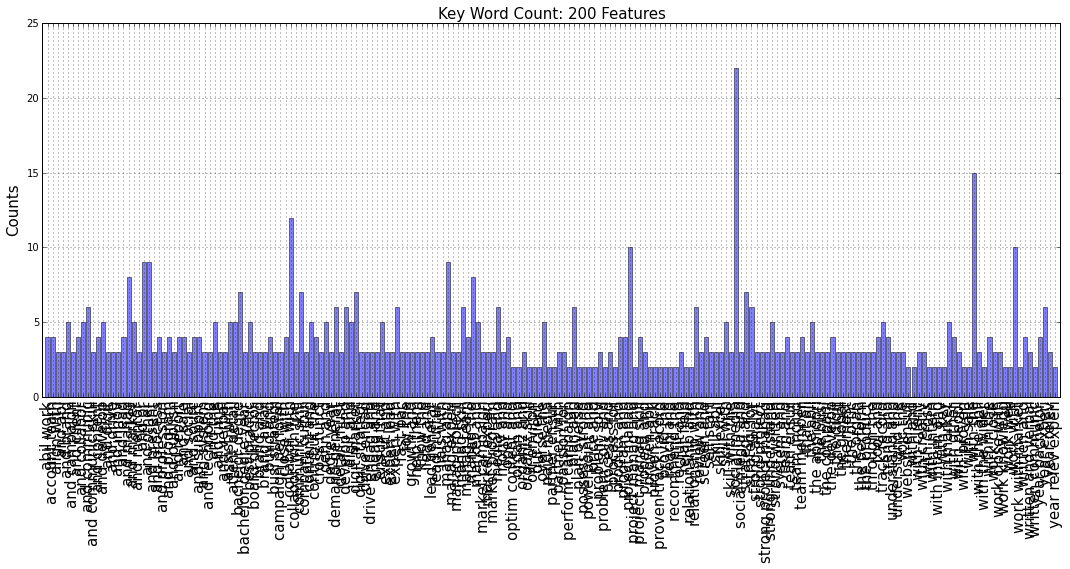

In [172]:
plt.figure(figsize=(15, 8))
ind.main()

indeed_scrape.Indeed() saves output to a file, assuming we are coming back to this notebook after some time...

In [173]:
import pandas as pd
df = pd.read_csv("data_frame.csv")
corpus = df['summary']

Take a look at how many job postings were returned.

In [174]:
df = df.drop_duplicates('url').dropna()
df['summary'].count()

17

## Bi-Gram for Less features

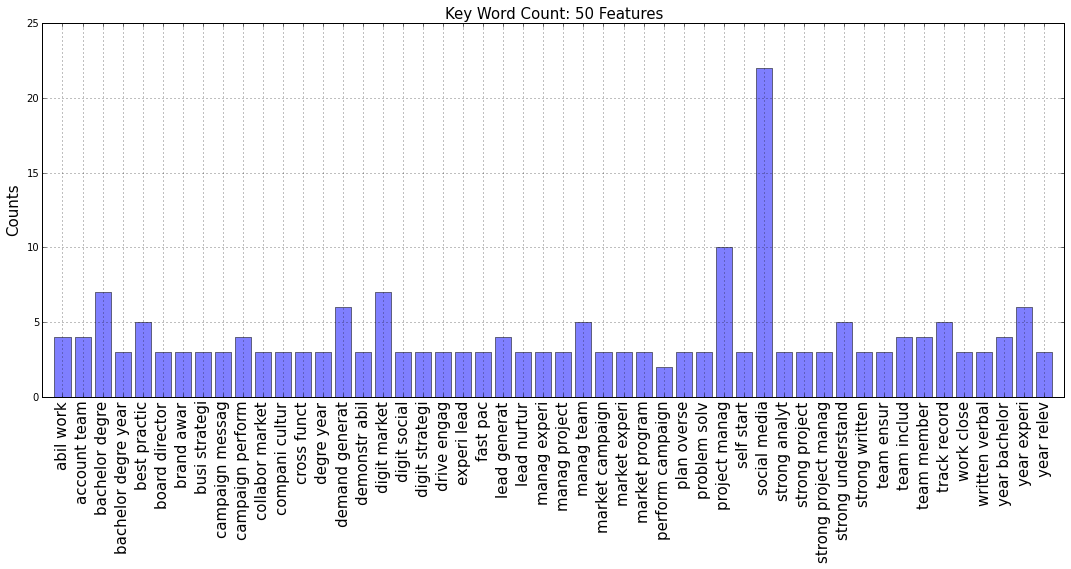

In [186]:
plt.figure(figsize=(15, 8))
mat, fea = ind.vectorizer(df['summary_stem'], max_df=0.8, max_features=50)
ind.plot_features(fea, mat)

## Monogram 
Above a Bi-gram analysis was performed by default. Let's include single words in the n-gram range,
(1,2), and using a corpus that has been stemmed with NLTK.

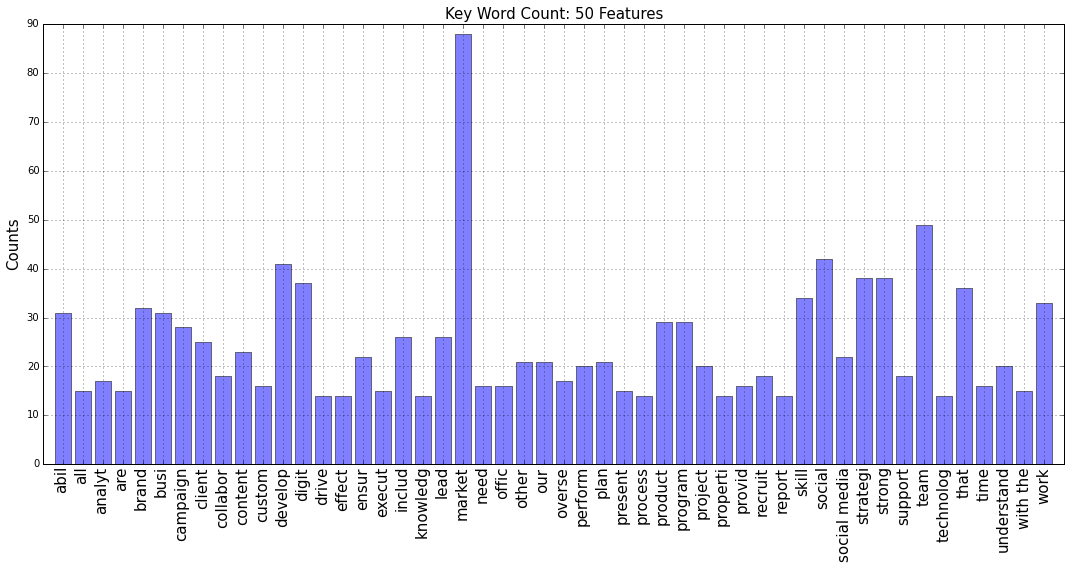

In [175]:
corpus_stem = df['summary_stem']
mat, fea = ind.vectorizer(corpus_stem,max_features=50, n_min=1)
plt.figure(figsize=(15,8))
ind.plot_features(fea, mat)

### Explore the Next 50 

<Container object of 10 artists>

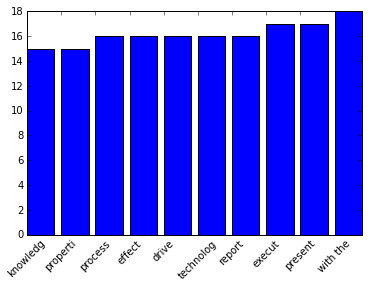

In [176]:
# tested with 10, change later
m = mat.toarray().sum(0)
ind_sort = np.argsort(m)
m = m[ind_sort]
f = np.array(fea)
f = f[ind_sort]
x = np.arange(10)
plt.xticks(x, f, rotation=45)
plt.bar(x, m[10:20])

## Explore High Count Words 
The word "experience" showed up with a high count. I want to know if there's more to that. Experience with a platform, technology, SQL or jusy previous analytic experiece. NLP is a deep rabbit hole, and I only peered a short ways down for this project. 

My word radius method gathers words to the left and right of a chosen keyword, and builds a corpus from within that radius. Then I apply the CountVectorizer again.

You'll notice that I need to write code to remove the keyword that was searched for, from the anlaysis.
Next iteration...

### Experience

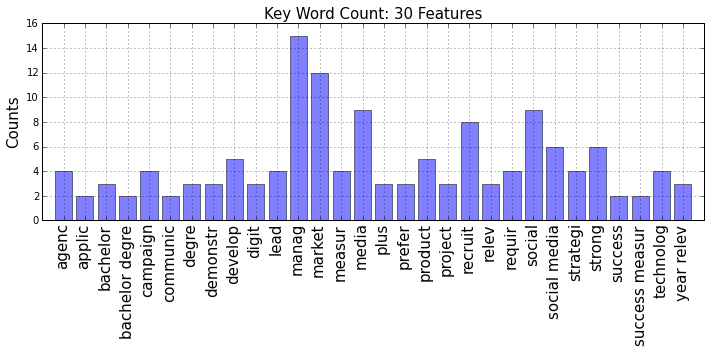

In [177]:
plt.figure(figsize=(10,5))
# adjust stop words
ind.stop_words = "experi" # note: stemmed version of experience
ind.add_stop_words()

words_in_radius = ind.find_words_in_radius(corpus_stem, 'experi', 5)
mat, fea = ind.vectorizer(words_in_radius, max_features=30, n_min=1)
ind.plot_features(fea, mat)

### Skills

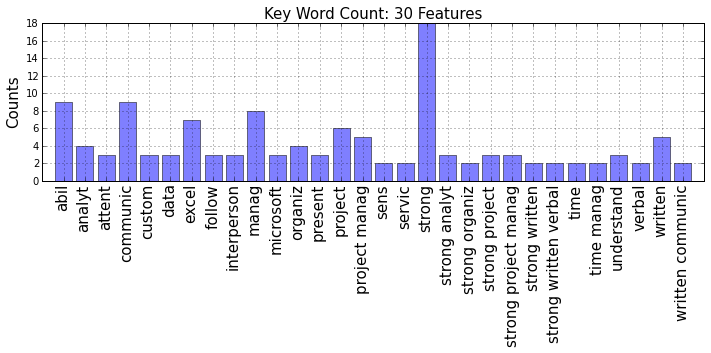

In [178]:
plt.figure(figsize=(10,5))
# adjust stop words
ind.stop_words = "skill"
ind.add_stop_words()

words_in_radius = ind.find_words_in_radius(corpus_stem, 'skill', 5)
mat, fea = ind.vectorizer(words_in_radius, max_features=30, n_min=1)
ind.plot_features(fea, mat)

## Job Postings Per City

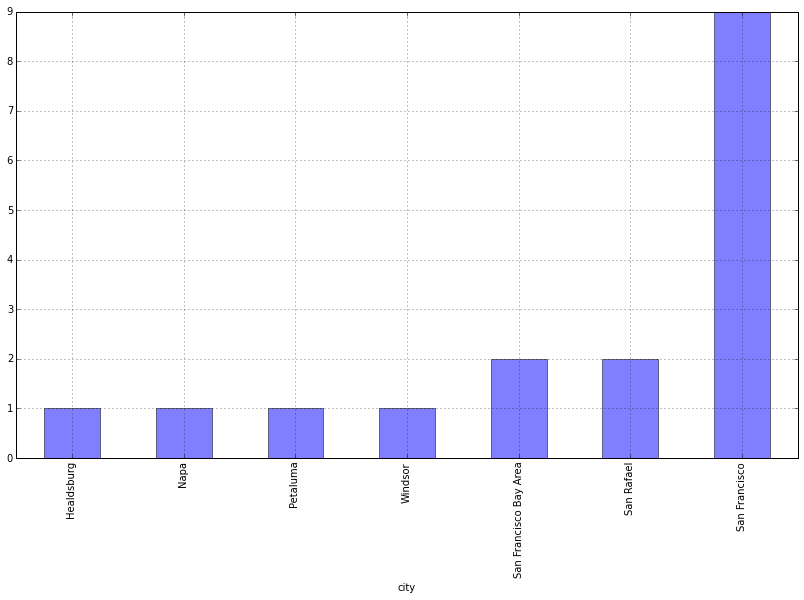

In [179]:
grp = df.groupby('city')
grp['url'].count().sort_values()[-20:].plot('bar', alpha=0.5, figsize=(14,8), grid=True)

## N-gram Analysis By Region

In [180]:
df['zipcode_prefix'] = df['zipcode'].apply(lambda x: x[0])

tot_fea = []
tot_mat = []

for prefix in df['zipcode_prefix'].unique():
    sub = df[df['zipcode_prefix'] == prefix]
    mat, fea = ind.vectorizer(sub['summary_stem'], max_df=0.9, n_min=1)
    mat = mat.toarray().sum(axis=0)
    tot_fea.append(fea)    
    tot_mat.append(mat)

IndexError: invalid index to scalar variable.